In [2]:
from TwitterAPI import TwitterAPI, TwitterOAuth, TwitterRequestError, TwitterConnectionError, TwitterPager
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline  
import tensorflow as tf
import tensorflow_hub as hub
from textblob import TextBlob
import seaborn as sns
import plotly.express as px
import re
import time

In [962]:
#Keys
auth = TwitterOAuth.read_file()
api = TwitterAPI(auth.consumer_key, auth.consumer_secret, auth.access_token_key, auth.access_token_secret, api_version='2')

In [963]:
#function to collect tweets
def collect_tweets(data):
    #create infinity loop
    while 1:  
        #make API call
        response = TwitterPager(api, 'tweets/search/recent', {
        #excludes retweets and replies in search query and tweets with hashtags and only includes English tweets
        'query':'jk rowling trans lang:en -is:retweet -is:reply',
        #collects tweet data such as when the tweet was created and the contents of the tweet
        'tweet.fields':'created_at,text',
        #collects the type of tweet it is, (eg. quoted)
        'expansions':'referenced_tweets.id',
        #collects tweets posted until 6/1 3 p.m. UTC (6/2 12 a.m. KST)
        'end_time':'2022-06-05T15:00:00Z',
        #maximum results that can be collected in a page is 100
        'max_results':100})
        time.sleep(1)
        
        #collect tweets
        for items in response.get_iterator(new_tweets=False):
            #collects type of tweet. if there is no referenced_tweets dictionary, it means that it is an original tweet
            if 'referenced_tweets' in items:
                tweet_type = items['referenced_tweets'][0]['type']
            else:
                tweet_type = "original_tweet"
        
            
            #collect tweet ID, time posted, and the content of the tweet
            tweet_id = items['id']
            time_created = items['created_at']
            time_created = str(time_created).split("T")[0]
            tweet_text = items['text']
            tweet_text = re.sub('@[^\s]+','',tweet_text)
            tweet_text = re.sub(r'http\S+','',tweet_text)
            tweet_text = re.sub('&amp;','',tweet_text)
            
            #append tweet details to dataframe
            tweet_data = {'tweet id': tweet_id, 'created at': time_created, 
                              'tweet type': tweet_type, 'contents':tweet_text}
            data = pd.concat([data, pd.DataFrame([tweet_data.values()], columns=data.columns)], ignore_index=True)
            data.to_csv(r'C:\Users\dania\Documents\경희대학교\웹 파이선프로그래밍\Term Project\term-project.csv')

        return data

In [964]:
#building the pandas dataframe
df = pd.DataFrame(columns=["tweet id", "created at", "tweet type", "contents"])
df = collect_tweets(df)

In [965]:
df.head()

,tweet id,created at,tweet type,contents
0,1533444025042079744,2022-06-05,original_tweet,BBC says it's 'misleading' to call JK Rowling'...
1,1533437278260969473,2022-06-05,quoted,I have 3 children and the books movies of JK ...
2,1533423561339047936,2022-06-05,original_tweet,In one trillion years there will be no more JK...
3,1533390036183715843,2022-06-05,original_tweet,"This is what supports, people. The eradicatio..."
4,1533385663612977152,2022-06-05,original_tweet,"Happy #pride babes ❤️🧡💛💚💙💜\n\nStay hydrated, k..."


In [3]:
def sentiment_analysis(tweet):
    def getSubjectivity(text):
        return TextBlob(text).sentiment.subjectivity

 #Create a function to get the polarity
    def getPolarity(text):
        return TextBlob(text).sentiment.polarity
    df['subjectivity'] = df['contents'].apply(getSubjectivity)
    df ['polarity'] = df['contents'].apply(getPolarity)

    def getAnalysis(score):
          if score < 0:
            return 'Negative'
          else:
            return 'Positive'

    df['analysis'] = df['polarity'].apply(getAnalysis)
    df.to_csv(r'C:\Users\dania\Documents\경희대학교\웹 파이선프로그래밍\Term Project\term-project2.csv')
    return tweet

In [4]:
#reads csv file containing dataframe
labeled_tweets = pd.read_csv(r'C:\Users\dania\Documents\경희대학교\Assignments\2022-1\웹 파이선프로그래밍\Term Project\term-project.csv')
#includes only the relevant columns
labeled_tweets = labeled_tweets[['contents', 'polarity']]
labeled_tweets.head()

,contents,polarity
0,BBC says it's 'misleading' to call JK Rowling'...,0.00
1,I have 3 children and the books movies of JK ...,0.00
2,In one trillion years there will be no more JK...,-0.25
3,"This is what supports, people. The eradicatio...",0.00
4,"Happy #pride babes ❤️🧡💛💚💙💜\n\nStay hydrated, k...",0.12


In [5]:
#creates train dataframe with 80% of the data, and a test set with the remaining 20%
train = labeled_tweets.sample(frac=0.8)
test = labeled_tweets.drop(train.index)

#turns columns into numpy arrays to use as inputs for training
train_examples, train_labels = train['contents'].values, train['polarity'].values
test_examples, test_labels = test['contents'].values, test['polarity'].values

In [7]:
#sets up a dictionary for tensorflow hub downloads to go to
os.environ['TFHUB_CACHE_DIR'] = r'C:\Users\dania\Documents\경희대학교\Assignments\2022-1\웹 파이선프로그래밍\Term Project\Tensorflow\modules'

#gets tokenization model from tensorflow hub to convert tweet content into numerical values
model = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)

#tokenization of an abstract to binary
hub_layer(train_examples[0:1])

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[ 0.081589  ,  0.25553998,  0.22297812, -0.04569394,  0.13906135,
        -0.02192794,  0.0774707 ,  0.1504151 , -0.21029918,  0.18105316,
        -0.01873645,  0.0036729 , -0.02360266, -0.14780858, -0.07385813,
         0.06839451, -0.12699349, -0.00535211, -0.09595597, -0.1194215 ,
        -0.15358247, -0.00797976,  0.15537   , -0.03752847,  0.03418913,
        -0.05970864,  0.19945809,  0.22616588,  0.01891819, -0.09462758,
        -0.00614163,  0.05823638, -0.06681056, -0.13008878,  0.33998197,
        -0.07141694,  0.0312359 , -0.1512539 ,  0.42089152,  0.02759735,
        -0.07519022,  0.0470535 ,  0.07031949, -0.12649062, -0.0604208 ,
         0.13147955,  0.14289495, -0.18422538, -0.02313073, -0.00282422,
         0.01233791,  0.04270147,  0.16826883,  0.32808587,  0.03410699,
        -0.0507715 ,  0.04202389, -0.23238783,  0.01053269, -0.08442033,
        -0.07323296,  0.10505539,  0.22014475, -0.07615229,  0.06068917,
 

In [8]:
#creates a Sequential neural network
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 124,644,897
Trainable params: 124,644,897
Non-trainable params: 0
_________________________________________________________________


In [9]:
# compiles model
# designed for binary classification
model.compile(optimizer='adam',
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [10]:
# sets aside some of the example datapoints for validation during training
x_val = train_examples[:70]
partial_x_train = train_examples[70:]

y_val = train_labels[:70]
partial_y_train = train_labels[70:]

print(len(x_val), len(partial_x_train))

70 98


In [11]:
#train the model
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=140,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10


c:\users\dania\appdata\local\programs\python\python39\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 4s 4s/step - loss: 0.7051 - accuracy: 0.1735 - val_loss: 0.6783 - val_accuracy: 0.2143
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.6749 - accuracy: 0.2245 - val_loss: 0.6575 - val_accuracy: 0.2429
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.6487 - accuracy: 0.2449 - val_loss: 0.6371 - val_accuracy: 0.2714
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.6257 - accuracy: 0.2551 - val_loss: 0.6162 - val_accuracy: 0.2857
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.6026 - accuracy: 0.2755 - val_loss: 0.5956 - val_accuracy: 0.3000
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 0.5800 - accuracy: 0.3061 - val_loss: 0.5753 - val_accuracy: 0.3000
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.5577 - accuracy: 0.3061 - val_loss: 0.5551 - val_accuracy: 0.3000
Epoch 8/10
1/1 [==============================] - 2s

In [12]:
# evaluate performance on test set
results = model.evaluate(test_examples, test_labels)
print(results)

2/2 [==============================] - 0s 156ms/step - loss: 0.4959 - accuracy: 0.3571
[0.4958720803260803, 0.3571428656578064]


2/2 [==============================] - 1s 162ms/step


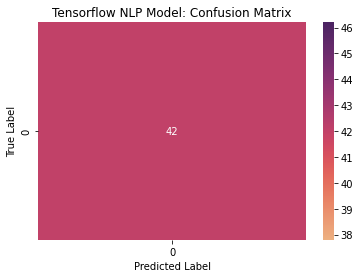

In [13]:
# visualize performance with a confusion matrix
predictions = (model.predict(test_examples) > 0.5).astype("int32")
predictions = [p[0] for p in predictions]
confusion_matrix = tf.math.confusion_matrix(test_labels, predictions)

ax = plt.axes()
sns.heatmap(confusion_matrix, cmap='flare', annot = True, fmt = 'd', ax = ax)
ax.set_title('Tensorflow NLP Model: Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

In [21]:
# gets TextBlob analysis
def sentiment_calc(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0 and random.random() > 0.5:
        return 1
    else: 
        return 0

In [22]:
# compares TextBlob with TensorFlow
correct = 0
incorrect = 0

for i in range(len(test_examples)):
    if test_labels[i] == sentiment_calc(test_examples[i]):
        correct +=1
    else:
        incorrect +=1
        
print('Accuracy: ', correct/(correct+incorrect))

Accuracy:  0.16666666666666666


In [23]:
# gets TensorFlow analysis results
def tensor_sentiment_calc(text):
    tensor_flow = (model.predict(['contents'])> 0.5).astype("int32")[0][0]
    if tensor_flow==1:
        return 'positive'
    else:
        return 'negative'

df['textblob'] = df['contents'].apply(sentiment_calc)
df['tensor'] = df['contents'].apply(tensor_sentiment_calc)

1/1 [==============================] - 0s 176ms/step


In [24]:
df.to_csv(r'C:\Users\dania\Documents\경희대학교\Assignments\2022-1\웹 파이선프로그래밍\Term Project\term-project-final.csv')

In [25]:
df.head()

,Unnamed: 0,tweet id,created at,tweet type,contents,subjectivity,polarity,analysis,textblob,tensor
0,0,1533444025042079744,2022-06-05,original_tweet,BBC says it's 'misleading' to call JK Rowling'...,0.00,0.00,Positive,0,negative
1,1,1533437278260969473,2022-06-05,quoted,I have 3 children and the books movies of JK ...,0.10,0.00,Positive,1,negative
2,2,1533423561339047936,2022-06-05,original_tweet,In one trillion years there will be no more JK...,0.50,-0.25,Negative,0,negative
3,3,1533390036183715843,2022-06-05,original_tweet,"This is what supports, people. The eradicatio...",0.00,0.00,Positive,0,negative
4,4,1533385663612977152,2022-06-05,original_tweet,"Happy #pride babes ❤️🧡💛💚💙💜\n\nStay hydrated, k...",0.64,0.12,Positive,1,negative
